# Importing Libraries

In [187]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


# Pathing

In [188]:
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
data_dir = os.path.join(project_dir, 'data')
raw_data_dir = os.path.join(data_dir, 'raw')
processed_data_dir = os.path.join(data_dir, 'processed')

# adding system path
sys.path.insert(0, project_dir)

# Internal Function

In [189]:
# import internal function
from src.data import process_pipeline

# Helper Function

In [190]:
def print_contents(filePath):
    for root, dirs, files in os.walk(filePath):
        for i in range(len(files)):
            print(f'{i}. {files[i]}')
            
def splitVar(data):
    conti = []
    categ = data.columns.to_list()

    for col in data:
        if data[col].nunique() > 100:
            conti.append(col)
            categ.remove(col)
    
    return conti, categ
    
def get_selected_features_and_model(X, y, categorical, continuous):
    # Numeric feature processing
    numeric_filter = SelectPercentile(f_classif, percentile=50)
    numeric_transformer = make_pipeline(numeric_filter, StandardScaler())

    # Categorical feature processing
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    categorical_filter = SelectPercentile(chi2, percentile=50)
    categorical_transformer = make_pipeline(ordinal_encoder, categorical_filter)

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, continuous),
            ("cat", categorical_transformer, categorical),
        ]
    )

    # Create the pipeline with logistic regression
    clf = make_pipeline(preprocessor, LogisticRegression())

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    clf.fit(X_train, y_train)

    # Get selected feature indices from numeric features
    numeric_selected_features = preprocessor.named_transformers_['num'].named_steps['selectpercentile'].get_support(indices=True)
    numeric_scores = preprocessor.named_transformers_['num'].named_steps['selectpercentile'].scores_

    # Get selected feature indices from categorical features
    categorical_selected_features = preprocessor.named_transformers_['cat'].named_steps['selectpercentile'].get_support(indices=True)
    categorical_scores = preprocessor.named_transformers_['cat'].named_steps['selectpercentile'].scores_

    # Combine both sets of selected features
    selected_features_indices = np.concatenate([numeric_selected_features, categorical_selected_features])

    # Get the names of the selected features
    selected_features_names = X.columns[selected_features_indices]

    # Print selected features with their scores
    print("Selected Features with Scores:")
    for feature, score in zip(selected_features_names, np.concatenate([numeric_scores, categorical_scores])):
        print(f"{feature}: {score}")

    return clf

def plot_confusion_matrix_custom(model, X_test, y_test, classes):
    # Predictions
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def evaluate_model_with_graph(model, X_test, y_test, classes):
    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy, Precision, Recall, F1 Score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    plot_confusion_matrix_custom(model, X_test, y_test, classes)

# Data Loading

In [191]:
# print files
print_contents(raw_data_dir)

0. carInsurance_test.csv
1. carInsurance_train.csv
2. DSS_DMC_Description.pdf


In [192]:
filePath = os.path.join(raw_data_dir, 'carInsurance_train.csv')
df = pd.read_csv(filePath)
df = process_pipeline.process_data(df)
df

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance,CallDuration
0,1,32,management,single,tertiary,0,1218,1,0,1,28,jan,2,-1,0,0,1900-01-01 13:45:20,1900-01-01 13:46:30,0,70.0
1,2,32,blue-collar,married,primary,0,1156,1,0,0,26,may,5,-1,0,0,1900-01-01 14:49:03,1900-01-01 14:52:08,0,185.0
2,3,29,management,single,tertiary,0,637,1,0,1,3,jun,1,119,1,0,1900-01-01 16:30:24,1900-01-01 16:36:04,1,340.0
3,4,25,student,single,primary,0,373,1,0,1,11,may,2,-1,0,0,1900-01-01 12:06:43,1900-01-01 12:20:22,1,819.0
4,5,30,management,married,tertiary,0,2694,0,0,1,3,jun,1,-1,0,0,1900-01-01 14:35:44,1900-01-01 14:38:56,0,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,28,technician,single,tertiary,0,0,1,0,1,25,may,1,40,2,0,1900-01-01 17:46:28,1900-01-01 17:50:57,1,269.0
3996,3997,49,admin.,divorced,secondary,0,124,1,1,1,29,jul,19,-1,0,0,1900-01-01 14:49:16,1900-01-01 14:51:21,0,125.0
3997,3998,27,admin.,single,secondary,0,-400,0,1,1,8,jul,1,-1,0,0,1900-01-01 12:19:03,1900-01-01 12:23:53,0,290.0
3998,3999,36,entrepreneur,single,tertiary,0,658,1,0,1,29,jan,1,227,3,0,1900-01-01 11:27:35,1900-01-01 11:29:14,0,99.0


In [193]:
# label
X = df.drop(columns=['CarInsurance'])

#target
y = df['CarInsurance']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# splitting between continous and categorical variable
conti, categ = splitVar(X)

In [194]:
conti

['Id', 'Balance', 'DaysPassed', 'CallStart', 'CallEnd', 'CallDuration']

In [195]:
conti.remove('CallStart')
conti.remove('CallEnd')

In [196]:
categ

['Age',
 'Job',
 'Marital',
 'Education',
 'Default',
 'HHInsurance',
 'CarLoan',
 'Communication',
 'LastContactDay',
 'LastContactMonth',
 'NoOfContacts',
 'PrevAttempts',
 'Outcome']

In [197]:
# Example usage:
model = get_selected_features_and_model(X, y, categ, conti)

Selected Features with Scores:
Job: 0.09722232864994351
Marital: 8.789153258611375
Age: 70.63488558351096
Default: 968.1212511139724
CarLoan: 33.91349586627674
LastContactDay: 51.764507298290994
LastContactMonth: 2.0979312516095945
NoOfContacts: 2.6591136965523585


Accuracy: 0.8037
Precision: 0.7759
Recall: 0.7205
F1 Score: 0.7472


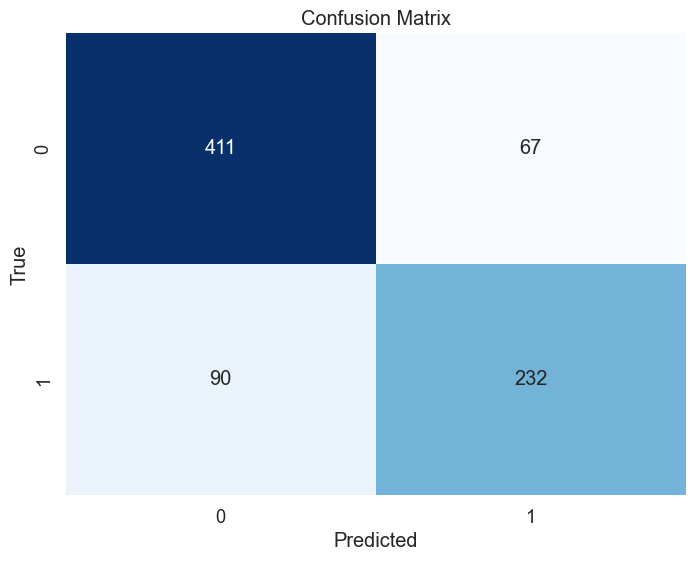

In [198]:
evaluate_model_with_graph(model, X_test, y_test, classes=['0', '1'])